<a href="https://colab.research.google.com/github/awhang/pytorch_fundamentals/blob/main/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

## What is a computer vision problem?

Binary classification
Multiclass classification
Object detection
Segmentation

What we'll do below:
- Getting a vision dataset to work with from torchvision.datasets
- Architecture of a convolutional neural network (CNN) with PyTorch
- End-toend multi-class image classification problem
- Steps in moddelling with CNNs in PyTorch
  - Creating a CNN model
  - Picking a loss and optimizer
  - Training and testing the model
  - Evaluate the model

## 0. Computer vision libraries in PyTorch
* `torchvision` base domain library for PyTorch computer vision
* `torchvision.datasets` - get data sets and data loading functions
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - base dataset class for PyTorch
* `torch.utils.data.Dataloader` - creates a Python iterable over a dataset

In [131]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

1.13.0+cu116
0.14.0+cu116


## 1. Getting a dataset

The dataset we'll be using is Fashion MNIST from torchvision.datasets


In [132]:
# Setup training data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data", # directory to download to
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data", # directory to download to
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [133]:
# Let's check how much data we have
len(train_data), len(test_data)

(60000, 10000)

In [134]:
# Let's view the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [135]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [136]:
# Check the shape of the image
print(f"Image shape: {image.shape} -> [color_channels, height, width]") # color channels is 1 because there's only 2 channels for black and white images
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### 1.1 Visualizing our data

Image shape: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

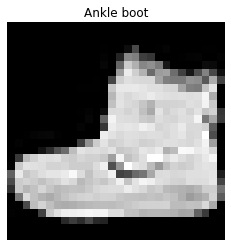

In [137]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray") # for black and white images, we can use .squeeze to remove the color channel
plt.title(class_names[label])
plt.axis(False) # remove axis
# image

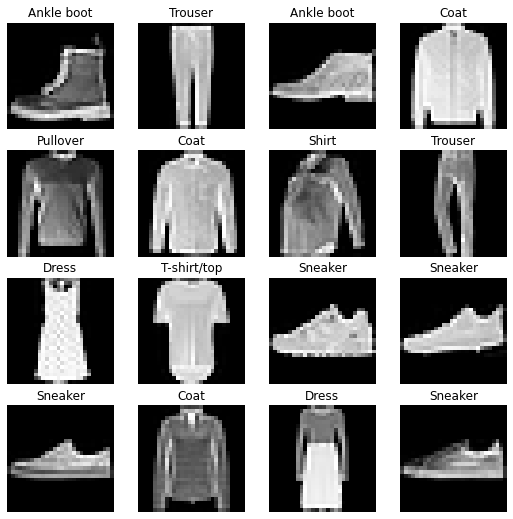

In [138]:
# Plot some more images

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i) # adds subplot at i index

  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## 2. Prepare Dataloader

Right now, the data is in the form of PyTorch datasets.CIFAR10

A DataLoader turns our dataset into a Python iterable.

We want to turn our data into batches (or mini-batches).

Why would we do this?
1. It is more computationally efficient since your hardware may not be able to store in memory your entire dataset in one go. A common batchsize is 32.
2. It gives our neural network more chances to update its gradients per epoch. Topic: *mini-batch gradient descent*


In [139]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn the datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False # often test data is not shuffled
                             )

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f1543c62340>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1543c621c0>)

In [140]:
# Let's check the data iterables we've just created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f1543c62340>, <torch.utils.data.dataloader.DataLoader object at 0x7f1543c621c0>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [141]:
# Checking the traning dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 8


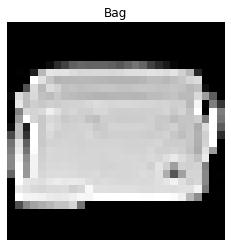

In [142]:
# Show a sample 

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, lbl = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[lbl])
plt.axis(False)

print(f"Image size: {img.shape}")
print(f"Label: {lbl}")

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

The baseline model is a simple model you will try and improve upon with subsequent models/experiments.

tldr: start simply and add complexity as needed.

In [143]:
# Create a flatten layer - This flattens the features so all pixel values are in one large vector
# We are doing this because a linear layer cannot take multi-dimensional/multi-feature tensors
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [144]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [145]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784, # this is 28 * 28, given by the flattened input shape
    hidden_units=10, # how many units in hidden layer
    output_shape=10 # amount of target classes
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [146]:
dummy_x = torch.rand([1, 1, 28, 28]).to(device)

model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 3.1 Setup loss, optimizer, and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent) 
* Evaluation metric- since we're working on a classification problem, let's use accuracy.

In [147]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download


In [148]:
# Setup loss funciton and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Two of the main things to track are:
1. Model performance ie. loss and accuracy values
2. How fast it runs

In [149]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and  end time.
  
  Example: 
    start_time = timer()
    # some code...
    end_time = timer()
    print_train_time(start=start_time, end=end_time, device="cpu")
  """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

### 3.3 Creating a training loop and training a model on batches of data

Note: The optimizer will update a model's parameter once per batch rather than once per epoch

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch
3. Loop through testing batches, perform testing steps, calculate the test loss per batch
4. Show what's happening
5. Time it

In [150]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start t he timer
torch.manual_seed(42)
train_time_start_on_model_0 = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create train and test loop
class TrainTestModule:

  def __init__(self, model, train_dataloader, test_dataloader):
    self.train_data = train_dataloader
    self.test_data = test_dataloader
    self.model = model

  def train_test(self):
    for epoch in tqdm(range(epochs)):
      print(f"Epoch: {epoch}\n-----")

      ### Training
      train_loss = self.train_batch()

      ### Testing
      test_loss, test_acc = self.test_batch()

      print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  def train_batch(self):
    train_loss = 0
    self.model.train()

    for batch, (X, y) in enumerate(self.train_data):
      # Put data on target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      y_pred = self.model(X)

      # Calculate loss per batch
      loss = loss_fn(y_pred, y)
      train_loss += loss

      # Optimizer zero grad
      optimizer.zero_grad()

      # Loss backward
      loss.backward()

      # Optimizer step
      optimizer.step()

      if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(self.train_data.dataset)} samples.")
    
    return train_loss / len(train_dataloader)
  
  def test_batch(self):
    self.model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
      for X_test, y_test in self.test_data:
        # Put test data on target device
        X_test, y_test = X_test.to(device), y_test.to(device)
        #Forward pass
        test_pred = self.model(X_test)

        # Calculate loss per batch
        test_loss += loss_fn(test_pred, y_test)

        # Calculate accuracy
        test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

      # Calculate the test loss average per batch
      test_loss /= len(self.test_data)
      test_acc /= len(self.test_data)
    
    return test_loss, test_acc

TrainTestModule(model_0, train_dataloader, test_dataloader).train_test()

# Calculate the training time
train_time_end_on_model_0 = timer()
total_train_time_on_model_0 = print_train_time(start=train_time_start_on_model_0,
                                           end=train_time_end_on_model_0,
                                           device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test loss: 0.5095 | Test acc: 82.0387
Epoch: 1
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test loss: 0.4799 | Test acc: 83.1969
Epoch: 2
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test loss: 0.4766 | Test acc: 83.4265
Train time on cuda:0: 27.710 seconds


## 4. Make predictions and get Model 0 results

In [151]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dict containing the results of the model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      # Make predictions
      y_pred = model(X)

      # Accumulate loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    # Find average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate the model = results on test datasett
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code (for using GPU when it exists)


In [152]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

In [153]:
from torch import nn

class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [154]:
torch.manual_seed(42)

# Setup model with input parameters
model_1 = FashionMNISTModelV1(
    input_shape=784, # this is 28 * 28, given by the flattened input shape
    hidden_units=10, # how many units in hidden layer
    output_shape=len(class_names) # amount of target classes
).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [155]:
# Setup loss funciton and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [156]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start t he timer
torch.manual_seed(42)
train_time_start_on_model_1 = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

TrainTestModule(model_1, train_dataloader, test_dataloader).train_test()

# Calculate the training time
train_time_end_on_model_1 = timer()
total_train_time_on_model_1 = print_train_time(start=train_time_start_on_model_1,
                                           end=train_time_end_on_model_1,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.6461 | Test loss: 0.5386 | Test acc: 80.7608
Epoch: 1
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4809 | Test loss: 0.4939 | Test acc: 82.4581
Epoch: 2
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4469 | Test loss: 0.4575 | Test acc: 83.9856
Train time on cuda: 33.397 seconds


## 7. Let's test Model 1 and get results

In [157]:
torch.manual_seed(42)

# Calculate the model = results on test datasett
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.45746350288391113,
 'model_acc': 83.98562300319489}

In [158]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 8. Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets
CNN's are known for their capabilities to find patterns in visual data.

### 8.1 Creating the CNN

In [159]:
# Creating the CNN

from torch import nn

class FashionMNISTModelV2(nn.Module):
  """
  This model will replicate the TinyVGG model
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.cnn_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.cnn_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.output_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # this needs to be calculated
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.cnn_layer_1(x)
    # print(x.shape)
    x = self.cnn_layer_2(x)
    # print(x.shape)
    x = self.output_layer(x)
    return x

In [160]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # 1 because we're dealing with black and white images
                              hidden_units=10,
                              output_shape=len(class_names)
                              ).to(device)

model_2

FashionMNISTModelV2(
  (cnn_layer_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [161]:
# Create random image tensor and send through model to check output shapes of each layer
rand_image_tensor = torch.randn(size=(1, 28, 28))
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 8.2 Training the CNN model

In [162]:
# Setup loss funciton and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [163]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start t he timer
torch.manual_seed(42)
train_time_start_on_model_2 = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

TrainTestModule(model_2, train_dataloader, test_dataloader).train_test()

# Calculate the training time
train_time_end_on_model_2 = timer()
total_train_time_on_model_2 = print_train_time(start=train_time_start_on_model_2,
                                           end=train_time_end_on_model_2,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5946 | Test loss: 0.4121 | Test acc: 85.2835
Epoch: 1
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.3645 | Test loss: 0.3571 | Test acc: 87.0108
Epoch: 2
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.3250 | Test loss: 0.3255 | Test acc: 88.3986
Epoch: 3
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.3045 | Test loss: 0.3225 | Test acc: 88.1090
Epoch: 4
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 s

### 8.3 Testing the CNN model

In [164]:
# Calculate the model = results on test datasett
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3027002215385437,
 'model_acc': 89.22723642172524}

## 9. Compare model results and training time

In [165]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.457464,83.985623
2,FashionMNISTModelV2,0.302700,89.227236


In [167]:
# Add training time to results comparison

compare_results["training_time"] = [total_train_time_on_model_0,
                                    total_train_time_on_model_1,
                                    total_train_time_on_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,27.709697
1,FashionMNISTModelV1,0.457464,83.985623,33.397331
2,FashionMNISTModelV2,0.302700,89.227236,56.546497


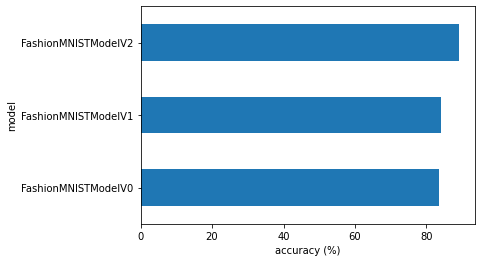

In [168]:
# Visualize the results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 10. Make and evaluate random predictions with best model

In [170]:
def make_preds(model: torch.nn.Module,
               data: list,
               device: torch.device = device) -> list:
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare sample (add a batch dim and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Put pred_prob onto cpu and append to prediction list
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [177]:
def probs_to_classes(pred_probs: list):
  return pred_probs.argmax(dim=1)

In [190]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

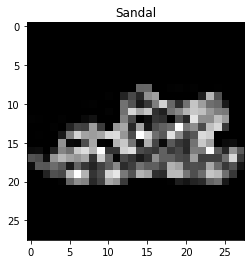

In [191]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [192]:
# Make predictions
pred_probs = make_preds(model=model_2,
                        data=test_samples)
pred_classes = probs_to_classes(pred_probs)

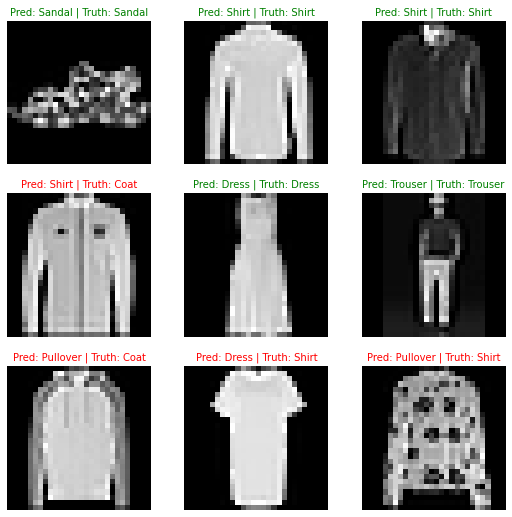

In [193]:
# Plot predictions
nrows = 3
ncols = 3
plt.figure(figsize=(9, 9))

for i, samples in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(samples.squeeze(), cmap="gray")

  # Find the prediction label in text form
  pred_label = class_names[pred_classes[i]]

  # Get true label
  true_label = class_names[test_labels[i]]

  # Create title
  title_text = f"Pred: {pred_label} | Truth: {true_label}"

  # Check for equality between prediction and truth
  if pred_label == true_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  
  plt.axis(False);